# Reproducing Experiment 1

For each of the nine weather contexts, we obtained the number of participants who gave each of the weather state ratings. By performing add-one Laplace smoothing on the counts, we computed a smoothed prior distribution over weather states given each context, namely $P(s)$ (Figure 3). 

In [1]:
import numpy as np
import pandas as pd
df = pd.read_csv("data/priors/long.csv")

In [2]:
df.sort_values(by=["imageID"])[:10] #just so we can see the data organized

,workerID,gender,age,income,language,order,imageID,imageCategory,stateRating,sad,disgusted,angry,neutral,content,happy,excited
102,13,F,45,0,English,4,1,amazing,4,0.21,0.04,0.04,0.42,0.81,0.68,0.52
337,39,F,45,4,English,5,1,amazing,5,0.04,0.06,0.05,0.42,0.42,0.82,0.76
149,18,M,25,6,English,6,1,amazing,5,0.02,0.20,0.14,0.14,0.75,0.83,0.69
221,26,F,65,4,English,6,1,amazing,4,0.01,0.02,0.01,0.53,0.98,0.86,0.80
251,29,F,25,4,English,9,1,amazing,5,0.29,0.06,0.06,0.60,0.74,0.84,0.47
40,5,M,35,4,English,5,1,amazing,5,0.00,0.00,0.01,0.52,1.00,1.00,0.88
136,17,M,35,4,English,2,1,amazing,5,0.02,0.01,0.02,0.17,0.91,0.97,0.97
134,16,F,45,8,English,9,1,amazing,5,0.00,0.00,0.00,0.42,0.73,0.86,0.48
350,40,M,65,4,english,9,1,amazing,4,0.02,0.02,0.01,0.10,0.93,0.78,0.60
47,7,M,35,4,English,3,1,amazing,4,0.30,0.14,0.29,0.39,0.51,0.54,0.53


In [3]:
groups = df[["imageID", "imageCategory", "stateRating"]].groupby('imageID')

value_counts = groups["stateRating"].value_counts()

counts = np.ones((9,5))
for val, cnt in value_counts.iteritems():
    img_id,state = val[0]-1,val[1]-1
    counts[img_id][state] = cnt + 1
    

priors = counts / counts.sum(axis=1,keepdims=True)  #normalize across rows
priors

priors[:3] = np.roll(priors[:3],2, axis=0)
priors[3:6] = np.roll(priors[3:6],2,axis=0)
priors[6:9] = np.roll(priors[6:9],2,axis=0)

### Recreate figure 3

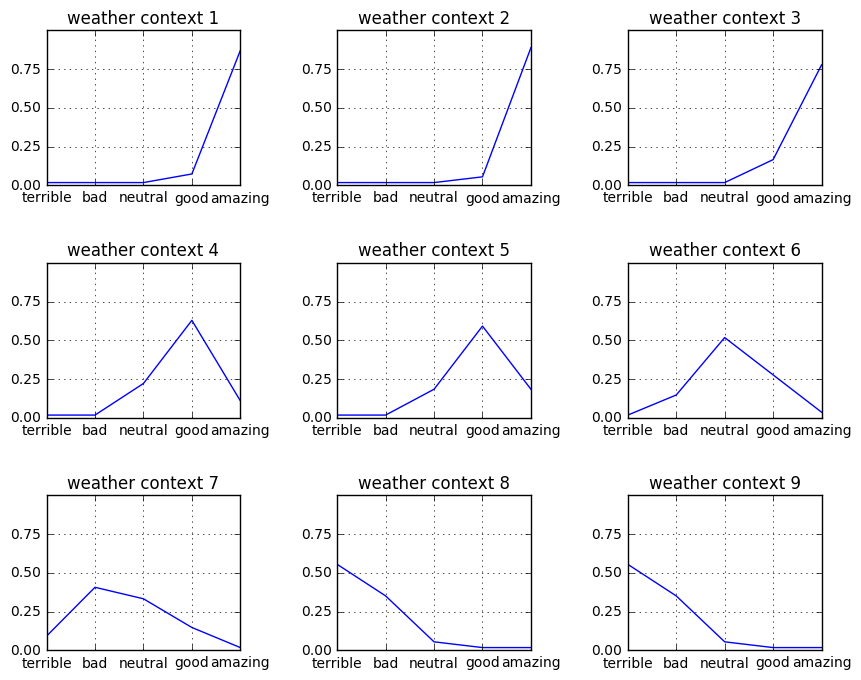

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))
labels = ["terrible", "bad", "neutral", "good", "amazing"]
x = np.arange(5)

for index, row in enumerate(priors,1):
    ax1 = fig.add_subplot(33*10+index)
    ax1.set_title("weather context %i"%(index))
    ax1.set_ylim(0, 1)
    ax1.plot(x,row.tolist())
    plt.grid()
    plt.xticks(x, labels) 
    plt.yticks(np.arange(0.0, 1.0, 0.25))
    

fig.subplots_adjust(hspace=.5, wspace=.5)
plt.show()

### Write priors to json file

In [5]:
import json

prior_states = {'WC'+str(i+1): dict(zip([1, 2, 3, 4, 5], priors[i].tolist())) for i in range(len(priors))}

with open('prior_states.json', 'w') as fp:
    fp.write(str(prior_states))

## PCA
To examine participants’ ratings of the affect associated. with each context, we first performed Principal Component Analysis (PCA) on the seven emotion category ratings. This allowed us to compress the ratings onto a lower-dimensional space and reveal the main affective dimensions that are important in this domain, as is often done in affective science (Russell, 1980).

In [6]:
def pca(m, k):
    from numpy.linalg import svd
    from numpy.linalg import eig
    from numpy.linalg import det
    u,s,v = svd(m)
    rs = np.sqrt(np.diag(s[:k]))
    x=np.dot(u[:,:k], rs)
    y=np.dot(rs, v[:k])
    mhat=np.dot(x, y)
    return s, x, y, mhat

In [7]:
from scipy import stats
affect = df[["imageID", "sad", "disgusted", "angry", "neutral", "content", "happy", "excited"]]
std_affect = stats.zscore(affect, axis=0)
s,affect_observ,affect_components,mhat = pca(std_affect,2)
affect_observ[:,1] = np.negative(affect_observ[:,1])

We found that the first two principal components corresponded to the dimensions of emotional valence and emotional arousal, accounting for 69.14% and 13.86% of the variance in the data, respectively. The PCA represents emotion ratings for each trial as real values between negative and positive infinity on each of the dimensions.

## Zero Mean + STD Var
To map these values onto probability space, we first standardized the scores on each dimension to have zero mean and unit variance. 

In [8]:
affect_observ = stats.zscore(affect_observ,axis=0) #this may not be necessary as the values outputted by PCA remain standardized
affect = affect.assign(pc1 = affect_observ[:,0], pc2 = affect_observ[:,1])

## CDF to (0,1)
We then used the cumulative distribution function to convert the standardized scores into values between 0 and 1. This gives us the probabilities of Ann feeling positive (vs. negative) valence and high (vs. low) arousal for each trial, which is a two-dimensional probabilistic representation of her affect.

In [9]:
def cdf(data):
    n = len(data)
    x = np.sort(data) # sort your data
    y = np.arange(1, n + 1) / n # calculate cumulative probability
    return x, y

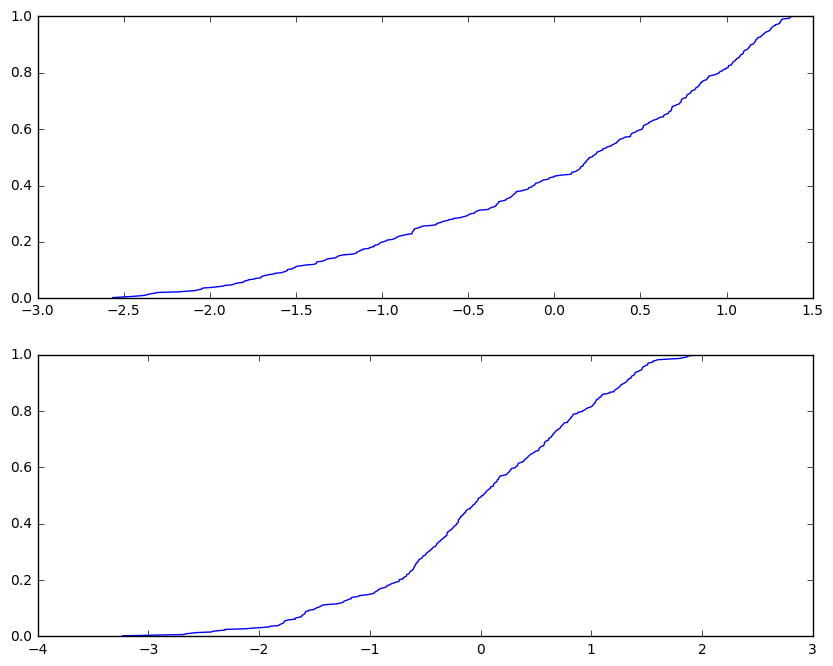

In [10]:
x0,y0 = cdf(affect_observ[:,0])
x1,y1 = cdf(affect_observ[:,1])

fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(211)
ax1.plot(x0,y0)
ax2 = fig.add_subplot(212)
ax2.plot(x1,y1)

plt.show()

the plots above give us "the probability of ann feeling positive valence & high arousal for each trial". Let's try a single trial and see what we get


It is not clear which principal component is valence and which one is arousal
nor do these values make much sense for "terrible".

, but given that they later project them into a binary space, they probably take the intervals from -INF to 0 in order to get the probability of negative valence/arousal and vice versa for positive valence/arousal

## Avg Probability for each state (across rows for each column)
By calculating the average probabilities of positive valence and high arousal given each weather state rating, we obtain the probability of positive valence and high arousal associated with each weather state, namely $P(A|s)$ (Figure 4).

so i imagine that here we group the rows by image and then find the avg probability

In [11]:
valence_cdf = [y0[np.where(x0 == val)[0][0]] for val in affect_observ[:,0]]
ids = np.array(df["stateRating"])
d = {'stateRating': ids, 'component 1 probability': valence_cdf}
valence_df = pd.DataFrame(data=d)
valence = valence_df.groupby('stateRating').mean()

In [12]:
arousal_cdf = [y1[np.where(x1 == val)[0][0]] for val in affect_observ[:,1]]
ids = np.array(df["stateRating"])
d = {'stateRating': ids, 'component 2 probability': arousal_cdf}
arousal_df = pd.DataFrame(data=d)
arousal = arousal_df.groupby('stateRating').mean()
print(arousal)

             component 2 probability
stateRating                         
1                           0.721747
2                           0.457944
3                           0.160464
4                           0.366074
5                           0.672145


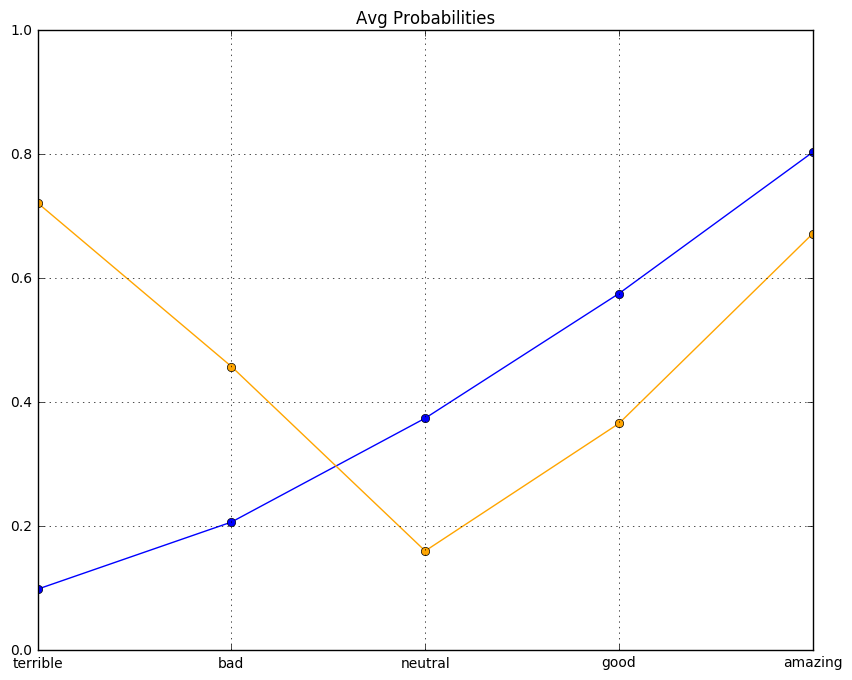

In [13]:
fig = plt.figure(figsize=(10, 8))
labels = ["terrible", "bad", "neutral", "good", "amazing"]
x = np.arange(5)


ax1 = fig.add_subplot(111)
ax1.set_title("Avg Probabilities")
ax1.set_ylim(0, 1)
ax1.plot(x,valence, color='blue',marker='o')
ax1.plot(x,arousal, color='orange',marker='o')
plt.grid()
plt.xticks(x, labels) 
plt.yticks(np.arange(0.0, 1.2, 0.2))


fig.subplots_adjust(hspace=.5, wspace=.5)
plt.show()

### Here we'll project the values of valence and arousal into binary space

In [14]:
def combo_priors(pos_val,high_arou):
    total_inst = len(valence_vals) 
    
    freq_count = {("positive","high"):0,
                ("negative","high"):0,
                ("positive","low"):0,
                ("negative","low"):0}
    for combo in zip(pos_val,high_arou):
        if combo == (1,1):
            freq_count[("positive","high")] += 1
        elif combo == (0,1):
            freq_count[("negative","high")] += 1
        elif combo == (1,0):
            freq_count[("positive","low")] += 1
        else:
            freq_count[("negative","low")] += 1
            
    priors = {k: v / total_inst for k, v in freq_count.items()}
    return priors

In [15]:
prior_affect = {}

for sRating in [1,2,3,4,5]:
    filtered_valence = valence_df.loc[valence_df['stateRating']==sRating]
    valence_vals = filtered_valence["component 1 probability"].values
    pos_val = (valence_vals >=.5).astype(int)
    
    filtered_arousal = arousal_df.loc[arousal_df['stateRating'] == sRating]
    arousal_vals = filtered_arousal["component 2 probability"].values
    high_arou = (arousal_vals >= .5).astype(int)
    
    prior_affect[sRating] = combo_priors(pos_val, high_arou)

In [16]:
#replace dictionary keys so that it may be compatible with Sameer's code
# sRating = [1,2,3,4,5]
# labels = ["terrible", "bad", "neutral", "good", "amazing"]

# for num,label in zip(sRating,labels):
#     prior_affect[label] = prior_affect.pop(num)
# prior_affect

prior_affect

{1: {('negative', 'high'): 0.8225806451612904,
  ('negative', 'low'): 0.1774193548387097,
  ('positive', 'high'): 0.0,
  ('positive', 'low'): 0.0},
 2: {('negative', 'high'): 0.453125,
  ('negative', 'low'): 0.546875,
  ('positive', 'high'): 0.0,
  ('positive', 'low'): 0.0},
 3: {('negative', 'high'): 0.058823529411764705,
  ('negative', 'low'): 0.8382352941176471,
  ('positive', 'high'): 0.0,
  ('positive', 'low'): 0.10294117647058823},
 4: {('negative', 'high'): 0.030612244897959183,
  ('negative', 'low'): 0.25510204081632654,
  ('positive', 'high'): 0.20408163265306123,
  ('positive', 'low'): 0.5102040816326531},
 5: {('negative', 'high'): 0.026845637583892617,
  ('negative', 'low'): 0.006711409395973154,
  ('positive', 'high'): 0.738255033557047,
  ('positive', 'low'): 0.22818791946308725}}

In [17]:
with open('prior_affect.json', 'w') as fp:
    fp.write(str(prior_affect))